# Using AI to Predict Server Hard Drive Failure

Project by Samy Djemaï during the LOG6309E course at Polytechnique Montréal.

Inspired by [*Predicting Disk Replacement Towards Reliable Data Centers* (Botezatu et al., 2016)](https://www.kdd.org/kdd2016/papers/files/adf0849-botezatuA.pdf).

## Abstract

Server hardware failures can cause unexpected crashes and downtime, which should be avoided at all costs for companies. Hard disk drive (HDD) failure is one of such failures. This project aims at predicting upcoming hard drive failures, using SMART statistics provided by the drives themselves as a multivariate time-series fed into a neural network to warn server operators of necessary disk replacements.

## Dataset Analysis

We first need to assess the dataset we are using, to find out which values are meaningful in our analysis.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import os
import pickle
from collections import defaultdict, Counter


In [3]:
df = pd.read_csv("data/Q1_2020/2020-03-31.csv")
df


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2020-03-31,Z305B2QN,ST4000DM000,4000787030016,0,114.0,72273728.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-31,ZJV0XJQ4,ST12000NM0007,12000138625024,0,84.0,226044912.0,NaN,NaN,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-31,ZJV0XJQ3,ST12000NM0007,12000138625024,0,83.0,207232920.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-31,ZJV0XJQ0,ST12000NM0007,12000138625024,0,82.0,176197928.0,NaN,NaN,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-31,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,143.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132334,2020-03-31,ZA10MCEQ,ST8000DM002,8001563222016,0,68.0,6560712.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132335,2020-03-31,ZCH0CRTK,ST12000NM0007,12000138625024,0,82.0,176676744.0,NaN,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132336,2020-03-31,ZA13ZBCT,ST8000DM002,8001563222016,0,83.0,204034056.0,NaN,NaN,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132337,2020-03-31,PL1331LAHGD9NH,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,134.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset contains 63 SMART attributes.

In [4]:
df.isnull().sum().sort_values(ascending=False).head(72)


smart_255_raw           132339
smart_250_normalized    132339
smart_15_raw            132339
smart_15_normalized     132339
smart_13_raw            132339
                         ...  
smart_22_raw            118912
smart_183_normalized    112270
smart_183_raw           112270
smart_8_raw              94583
smart_8_normalized       94583
Length: 72, dtype: int64

Some SMART stats are not reported by any drive in the dataset. We can drop around 35 SMART attributes (= 70 columns) without losing too much information: when sorted in descending order, we remove all SMART attributes with more `NaN` values than `SMART_8`.


In [5]:
df1 = df.dropna(axis=1, thresh=int(0.2 * df.shape[0]))
df1


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_199_normalized,smart_199_raw,smart_200_normalized,smart_200_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
0,2020-03-31,Z305B2QN,ST4000DM000,4000787030016,0,114.0,72273728.0,NaN,NaN,91.0,...,200.0,0.0,NaN,NaN,100.0,37370.0,100.0,5.445219e+10,100.0,2.796870e+11
1,2020-03-31,ZJV0XJQ4,ST12000NM0007,12000138625024,0,84.0,226044912.0,NaN,NaN,89.0,...,200.0,0.0,100.0,0.0,100.0,13860.0,100.0,5.294202e+10,100.0,1.640811e+11
2,2020-03-31,ZJV0XJQ3,ST12000NM0007,12000138625024,0,83.0,207232920.0,NaN,NaN,98.0,...,200.0,0.0,100.0,0.0,100.0,11332.0,100.0,5.228804e+10,100.0,7.951115e+10
3,2020-03-31,ZJV0XJQ0,ST12000NM0007,12000138625024,0,82.0,176197928.0,NaN,NaN,93.0,...,200.0,0.0,100.0,0.0,100.0,15015.0,100.0,5.540053e+10,100.0,1.339848e+11
4,2020-03-31,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,143.0,...,200.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132334,2020-03-31,ZA10MCEQ,ST8000DM002,8001563222016,0,68.0,6560712.0,NaN,NaN,92.0,...,200.0,0.0,NaN,NaN,100.0,33084.0,100.0,8.139620e+10,100.0,1.917751e+11
132335,2020-03-31,ZCH0CRTK,ST12000NM0007,12000138625024,0,82.0,176676744.0,NaN,NaN,97.0,...,200.0,0.0,100.0,0.0,100.0,18576.0,100.0,6.776489e+10,100.0,1.413963e+11
132336,2020-03-31,ZA13ZBCT,ST8000DM002,8001563222016,0,83.0,204034056.0,NaN,NaN,89.0,...,200.0,0.0,NaN,NaN,100.0,29184.0,100.0,7.229272e+10,100.0,1.965452e+11
132337,2020-03-31,PL1331LAHGD9NH,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,134.0,100.0,100.0,...,200.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now want to know which drives report the most SMART values.

In [6]:
df2 = df1.drop(df1.filter(like="normalized", axis=1).columns, axis=1)
df2.drop(labels=["date", "capacity_bytes"], axis=1, inplace=True)
df2


,serial_number,model,failure,smart_1_raw,smart_2_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_8_raw,...,smart_194_raw,smart_195_raw,smart_196_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,Z305B2QN,ST4000DM000,0,72273728.0,NaN,0.0,19.0,0.0,5.774153e+07,NaN,...,22.0,NaN,NaN,0.0,0.0,0.0,NaN,37370.0,5.445219e+10,2.796870e+11
1,ZJV0XJQ4,ST12000NM0007,0,226044912.0,NaN,0.0,9.0,0.0,7.462914e+08,NaN,...,27.0,226044912.0,NaN,0.0,0.0,0.0,0.0,13860.0,5.294202e+10,1.640811e+11
2,ZJV0XJQ3,ST12000NM0007,0,207232920.0,NaN,0.0,2.0,0.0,2.378736e+08,NaN,...,31.0,207232920.0,NaN,0.0,0.0,0.0,0.0,11332.0,5.228804e+10,7.951115e+10
3,ZJV0XJQ0,ST12000NM0007,0,176197928.0,NaN,0.0,6.0,0.0,7.546835e+08,NaN,...,24.0,176197928.0,NaN,0.0,0.0,0.0,0.0,15015.0,5.540053e+10,1.339848e+11
4,PL1331LAHG1S4H,HGST HMS5C4040ALE640,0,0.0,103.0,543.0,12.0,0.0,0.000000e+00,42.0,...,29.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132334,ZA10MCEQ,ST8000DM002,0,6560712.0,NaN,0.0,4.0,8.0,3.544600e+09,NaN,...,24.0,6560712.0,NaN,0.0,0.0,0.0,NaN,33084.0,8.139620e+10,1.917751e+11
132335,ZCH0CRTK,ST12000NM0007,0,176676744.0,NaN,0.0,3.0,0.0,4.197787e+08,NaN,...,22.0,176676744.0,NaN,0.0,0.0,0.0,0.0,18576.0,6.776489e+10,1.413963e+11
132336,ZA13ZBCT,ST8000DM002,0,204034056.0,NaN,0.0,6.0,0.0,3.351355e+09,NaN,...,33.0,204034056.0,NaN,0.0,0.0,0.0,NaN,29184.0,7.229272e+10,1.965452e+11
132337,PL1331LAHGD9NH,HGST HMS5C4040BLE640,0,0.0,100.0,459.0,7.0,0.0,0.000000e+00,42.0,...,33.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [7]:
for row in df2.head(2).iterrows():
    print(row)

(0, serial_number          Z305B2QN
model               ST4000DM000
failure                       0
smart_1_raw          72273728.0
smart_2_raw                 NaN
smart_3_raw                 0.0
smart_4_raw                19.0
smart_5_raw                 0.0
smart_7_raw          57741526.0
smart_8_raw                 NaN
smart_9_raw             37623.0
smart_10_raw                0.0
smart_12_raw               19.0
smart_184_raw               0.0
smart_187_raw               0.0
smart_188_raw               0.0
smart_189_raw               0.0
smart_190_raw              22.0
smart_191_raw               0.0
smart_192_raw               0.0
smart_193_raw           34383.0
smart_194_raw              22.0
smart_195_raw               NaN
smart_196_raw               NaN
smart_197_raw               0.0
smart_198_raw               0.0
smart_199_raw               0.0
smart_200_raw               NaN
smart_240_raw           37370.0
smart_241_raw     54452189896.0
smart_242_raw    279687006947.0
Name

In [8]:
df2.groupby(by="model").agg(lambda x: int(x.isnull().mean())).sum(axis=1).sort_values(
    ascending=True
)


model
ST10000NM0086                              3
ST6000DM001                                4
ST6000DM004                                4
ST6000DX000                                4
ST8000DM004                                4
ST8000DM005                                4
ST8000NM0055                               4
ST8000DM002                                4
ST500LM021                                 5
ST4000DM000                                5
ST4000DM005                                5
ST500LM030                                 5
ST12000NM0007                              6
ST12000NM0008                              6
ST16000NM001G                              7
WDC WD5000BPKT                             8
TOSHIBA MQ01ABF050M                        9
TOSHIBA MQ01ABF050                         9
TOSHIBA MG08ACA16TA                        9
TOSHIBA HDWE160                            9
TOSHIBA HDWF180                            9
ST500LM012 HN                              9
TOSH

In [9]:
df2.groupby(by="model").agg(lambda x: int(x.isnull().mean())).sum(axis=0).sort_values(
    ascending=False
)


smart_200_raw    34
smart_189_raw    32
smart_184_raw    32
smart_195_raw    32
smart_190_raw    29
smart_188_raw    29
smart_187_raw    29
smart_2_raw      25
smart_8_raw      25
smart_241_raw    22
smart_242_raw    22
smart_191_raw    21
smart_196_raw    21
smart_240_raw    20
smart_193_raw     8
smart_199_raw     6
smart_7_raw       6
smart_5_raw       6
smart_3_raw       6
smart_10_raw      6
smart_4_raw       6
smart_197_raw     6
smart_198_raw     6
smart_12_raw      1
smart_1_raw       1
smart_194_raw     1
smart_192_raw     1
smart_9_raw       1
failure           0
serial_number     0
dtype: int64

We can notice that Seagate drives report the most SMART parameters, followed by Western Digital, Toshiba and Hitachi drives. Seagate BarraCuda SSDs and DELLBOSS VD drives do not provide useful information.

In [10]:
df2.groupby(by="model").agg({"serial_number": "count"}).sort_values(
    by="serial_number", ascending=False
)


,serial_number
model,
ST12000NM0007,36997
ST4000DM000,19142
ST8000NM0055,14464
HGST HMS5C4040BLE640,12744
ST12000NM0008,10876
HGST HUH721212ALN604,10847
ST8000DM002,9793
TOSHIBA MG07ACA14TA,7200
HGST HMS5C4040ALE640,2896


The datacenter is mostly populated by Seagate drives, especially the ST12000NM0007 and ST4000DM000 models.

Now, let's take a look at the models which fail the most, in order to get a better set of failing drives. We will be using all data from Q1 2020.

In [11]:
failure_dict = defaultdict(lambda: [0, 0])
with open("data/Q1_2020.csv") as f:
    for line in f:
        if "failure" not in line:
            line = line.rstrip()
            split_line = line.split(",")
            fail = split_line[4]
            failure_dict[split_line[2]][int(fail)] += 1

print(failure_dict)


defaultdict(<function <lambda> at 0x7f165ecfd790>, {'ST4000DM000': [1744529, 68], 'ST12000NM0007': [3368588, 126], 'HGST HMS5C4040ALE640': [260803, 4], 'ST8000NM0055': [1315654, 46], 'ST8000DM002': [891567, 18], 'HGST HMS5C4040BLE640': [1159683, 9], 'HGST HUH721212ALN604': [987616, 14], 'TOSHIBA MG07ACA14TA': [460212, 16], 'HGST HUH721212ALE600': [141934, 0], 'ST10000NM0086': [109196, 4], 'ST12000NM0008': [750681, 29], 'ST6000DX000': [80624, 1], 'TOSHIBA MQ01ABF050': [39102, 39], 'ST500LM030': [22677, 7], 'DELLBOSS VD': [5459, 0], 'TOSHIBA MQ01ABF050M': [37251, 9], 'WDC WD5000LPVX': [18736, 4], 'ST500LM012 HN': [43679, 13], 'HGST HUH728080ALE600': [91000, 0], 'TOSHIBA MD04ABA400V': [9009, 0], 'TOSHIBA HDWF180': [1820, 0], 'ST8000DM005': [2275, 0], 'ST4000DM005': [3549, 0], 'Seagate SSD': [9793, 0], 'Seagate BarraCuda SSD ZA250CM10002': [21684, 3], 'HGST HUH721010ALE600': [1820, 0], 'WDC WD5000LPCX': [4900, 1], 'HGST HDS5C4040ALE630': [2366, 0], 'ST16000NM001G': [5036, 0], 'ST500LM021':

In [12]:
failure_rate_dict = {k: [v[0], v[1], v[1] / v[0]] for k, v in failure_dict.items()}

failure_rate_df = (
    pd.DataFrame.from_dict(
        failure_rate_dict,
        orient="index",
        columns=["count", "fail_count", "failure_rate"],
    )
    .sort_values("failure_rate", ascending=False)
    .style.format({"failure_rate": "{:.4%}"})
)
failure_rate_df


,count,fail_count,failure_rate
ST8000DM004,209,1,0.4785%
TOSHIBA MQ01ABF050,39102,39,0.0997%
ST500LM030,22677,7,0.0309%
ST500LM012 HN,43679,13,0.0298%
TOSHIBA MQ01ABF050M,37251,9,0.0242%
WDC WD5000LPVX,18736,4,0.0213%
WDC WD5000LPCX,4900,1,0.0204%
Seagate BarraCuda SSD ZA250CM10002,21684,3,0.0138%
ST4000DM000,1744529,68,0.0039%
ST12000NM0008,750681,29,0.0039%


Upon analysis of the dataset, we can determine that two drives seem to be of interest:
- **Seagate ST4000DM000**
    - reports almost all SMART parameters
    - is one of the most used drives
    - has a high failure rate, which provides more failing individuals
- **Seagate ST12000NM0007**
    - reports slightly less SMART parameters
    - is the most used drive in the datacenter
    - has a similar failure rate

We will study the impact of various SMART parameters on the **Seagate ST4000DM000**, train the ML models on it and finally generalize to other drives, including the **Seagate ST12000NM0007**.

In [13]:
%%time

column_names = "date,serial_number"
column_names = column_names.split(",")
failed_st4000dm000_drives = pd.DataFrame(columns=column_names)

for filename in [
    "data/Q1_2019.csv",
    "data/Q2_2019.csv",
    "data/Q3_2019.csv",
    "data/Q4_2019.csv",
    "data/Q1_2020.csv",
    "data/Q2_2020.csv",
    "data/Q3_2020.csv",
        "data/Q4_2020.csv"]:
    with open(filename) as f:
        for line in f:
            line = line.rstrip()
            if "ST4000DM000" in line:
                split_line = line.split(",")
                fail = split_line[4]
                if fail == "1":
                    failed_st4000dm000_drives.loc[len(failed_st4000dm000_drives)] = [
                        split_line[0], split_line[1]]
    print(f"{filename} done")

failed_st4000dm000_drives.date = pd.to_datetime(
    failed_st4000dm000_drives["date"], format="%Y-%m-%d")
failed_st4000dm000_drives.set_index(["date"], inplace=True)
failed_st4000dm000_drives.sort_index(inplace=True)

failed_st4000dm000_drives


data/Q1_2019.csv done
data/Q2_2019.csv done
data/Q3_2019.csv done
data/Q4_2019.csv done
data/Q1_2020.csv done
data/Q2_2020.csv done
data/Q3_2020.csv done
data/Q4_2020.csv done
CPU times: user 2min 25s, sys: 10.8 s, total: 2min 36s
Wall time: 2min 36s


,serial_number
date,
2019-01-01,S300YTAY
2019-01-01,S300ZREZ
2019-01-02,Z302T6AB
2019-01-02,Z3026Q5Y
2019-01-03,W300THEG
...,...
2020-12-24,Z304HV25
2020-12-25,S301GQPM
2020-12-25,Z305D5CQ


In [130]:
%%time

column_names = "date,serial_number"
column_names = column_names.split(",")
failed_st12000nm0007_drives = pd.DataFrame(columns=column_names)

for filename in [
    "data/Q1_2019.csv",
    "data/Q2_2019.csv",
    "data/Q3_2019.csv",
    "data/Q4_2019.csv",
    "data/Q1_2020.csv",
    "data/Q2_2020.csv",
    "data/Q3_2020.csv",
        "data/Q4_2020.csv"]:
    with open(filename) as f:
        for line in f:
            line = line.rstrip()
            if "ST12000NM0007" in line:
                split_line = line.split(",")
                fail = split_line[4]
                if fail == "1":
                    failed_st12000nm0007_drives.loc[len(failed_st12000nm0007_drives)] = [
                        split_line[0], split_line[1]]
    print(f"{filename} done")

failed_st12000nm0007_drives.date = pd.to_datetime(
    failed_st12000nm0007_drives["date"], format="%Y-%m-%d")
failed_st12000nm0007_drives.set_index(["date"], inplace=True)
failed_st12000nm0007_drives.sort_index(inplace=True)

failed_st12000nm0007_drives


data/Q1_2019.csv done
data/Q2_2019.csv done
data/Q3_2019.csv done
data/Q4_2019.csv done
data/Q1_2020.csv done
data/Q2_2020.csv done
data/Q3_2020.csv done
data/Q4_2020.csv done
CPU times: user 3min 15s, sys: 13.8 s, total: 3min 29s
Wall time: 3min 29s


,serial_number
date,
2019-01-02,ZCH07RLC
2019-01-03,ZCH0C6VX
2019-01-03,ZCH08BSC
2019-01-03,ZCH0931T
2019-01-04,ZCH075WD
...,...
2020-12-21,ZCH06GVN
2020-12-23,ZJV5GMMD
2020-12-26,ZJV5ND3B


In [140]:
failed_st12000nm0007_drives[failed_st12000nm0007_drives.serial_number == "ZCH06VE2"]

,serial_number
date,
2019-03-19,ZCH06VE2


## Case study: drive no. Z305AQY2

In [14]:
smart_dict = {}
with open("smart_titles") as f:
    for line in f:
        split_line = line.rstrip().split("\t")
        smart_dict[f"smart_{split_line[0]}_raw"] = split_line[1]


In [15]:
column_names = "date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_16_normalized,smart_16_raw,smart_17_normalized,smart_17_raw,smart_18_normalized,smart_18_raw,smart_22_normalized,smart_22_raw,smart_23_normalized,smart_23_raw,smart_24_normalized,smart_24_raw,smart_168_normalized,smart_168_raw,smart_170_normalized,smart_170_raw,smart_173_normalized,smart_173_raw,smart_174_normalized,smart_174_raw,smart_177_normalized,smart_177_raw,smart_179_normalized,smart_179_raw,smart_181_normalized,smart_181_raw,smart_182_normalized,smart_182_raw,smart_183_normalized,smart_183_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_189_normalized,smart_189_raw,smart_190_normalized,smart_190_raw,smart_191_normalized,smart_191_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_195_normalized,smart_195_raw,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_200_normalized,smart_200_raw,smart_201_normalized,smart_201_raw,smart_218_normalized,smart_218_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_231_normalized,smart_231_raw,smart_232_normalized,smart_232_raw,smart_233_normalized,smart_233_raw,smart_235_normalized,smart_235_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw"
column_names = column_names.split(",")

case_df = pd.DataFrame(columns=column_names)
for filename in os.listdir("data/Q1_2020"):
    with open(f"data/Q1_2020/{filename}") as f:
        for line in f:
            if "Z305AQY2,ST4000DM000" in line:
                line = line.rstrip()
                split_line = line.split(",")
                case_df.loc[len(case_df)] = split_line


In [102]:
case_df


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2020-01-01,Z305AQY2,ST4000DM000,4000787030016,0,108,16764696,,,99,...,,,,,,,,,,
1,2020-01-02,Z305AQY2,ST4000DM000,4000787030016,0,117,138177592,,,99,...,,,,,,,,,,
2,2020-01-03,Z305AQY2,ST4000DM000,4000787030016,0,117,129309520,,,99,...,,,,,,,,,,
3,2020-01-04,Z305AQY2,ST4000DM000,4000787030016,0,108,17993912,,,99,...,,,,,,,,,,
4,2020-01-05,Z305AQY2,ST4000DM000,4000787030016,0,117,151128664,,,99,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2020-03-11,Z305AQY2,ST4000DM000,4000787030016,0,114,64081336,,,98,...,,,,,,,,,,
68,2020-01-18,Z305AQY2,ST4000DM000,4000787030016,0,118,180687256,,,99,...,,,,,,,,,,
69,2020-02-05,Z305AQY2,ST4000DM000,4000787030016,0,111,32740712,,,99,...,,,,,,,,,,
70,2020-02-23,Z305AQY2,ST4000DM000,4000787030016,0,112,42780760,,,98,...,,,,,,,,,,


In [108]:
def drive_df_preprocess(df: pd.DataFrame, date_as_index=False) -> pd.DataFrame:
    p_df = df.copy(deep=True)
    # Convert date from string to datetime
    p_df.date = pd.to_datetime(p_df["date"], format="%Y-%m-%d")
    if date_as_index:
        # Set date as index, and sort by date
        p_df.set_index(["date"], inplace=True)
        p_df.sort_index(inplace=True)
    # Replace all empty cells by NaN values
    p_df.replace(r"^\s*$", np.nan, regex=True, inplace=True)
    # Drop columns with only NaN values
    p_df.dropna(axis=1, how="all", inplace=True)
    # Drop normalized SMART values
    # p_df.drop(p_df.filter(like="normalized", axis=1).columns, axis=1, inplace=True)
    # Drop useless values
    p_df.drop(
        ["model", "capacity_bytes"], axis=1, inplace=True
    )
    cols = [col for col in p_df.columns if col not in ["date", "serial_number"]]
    for col in cols:
        p_df[col] = pd.to_numeric(p_df[col])
    return p_df


def smart_changepoints(df: pd.DataFrame, display=False) -> Counter:
    changepoint_counter = Counter()
    work_df = df.drop(["serial_number", "failure"], axis=1)
    for col in work_df.columns:
        signal = work_df[col].to_numpy()
        algo = rpt.Pelt(model="rbf").fit(signal)
        # algo = rpt.Dynp(model="l1", min_size=5).fit(work_df[col].to_numpy())
        # algo = rpt.Window(width=10).fit(work_df[col].to_numpy())
        result = algo.predict(pen=16)
        # result = algo.predict(n_bkps=1)
        changepoint_counter[col] += min(1, len(result) - 1)
        if display:
            print(f"{smart_dict.get(col, 'Normalized')} ({col})")
            rpt.display(work_df[col], [], result)
            plt.show()

    return changepoint_counter


Normalized (smart_1_normalized)


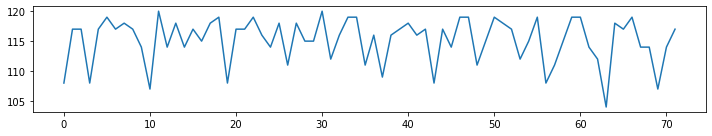

Read Error Rate (smart_1_raw)


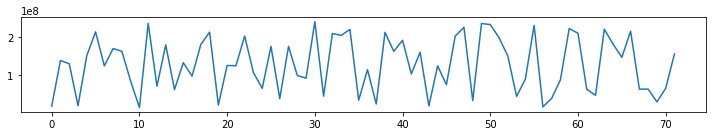

Normalized (smart_3_normalized)


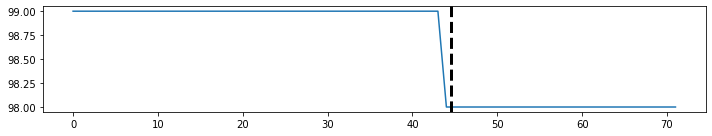

Spin-Up Time (smart_3_raw)


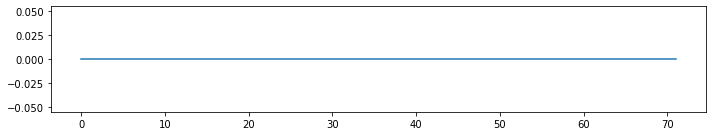

Normalized (smart_4_normalized)


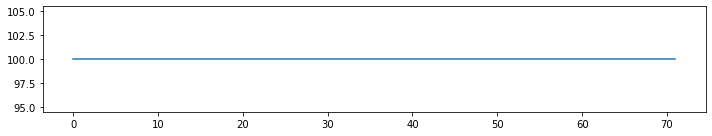

Start/Stop Count (smart_4_raw)


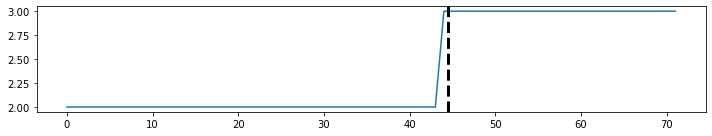

Normalized (smart_5_normalized)


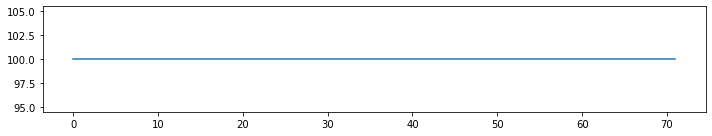

Reallocated Sectors Count (smart_5_raw)


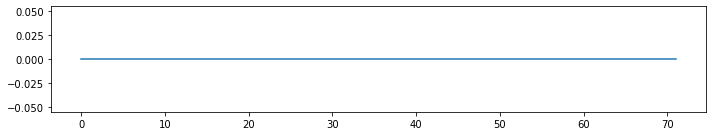

Normalized (smart_7_normalized)


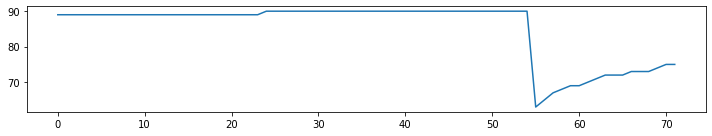

Seek Error Rate (smart_7_raw)


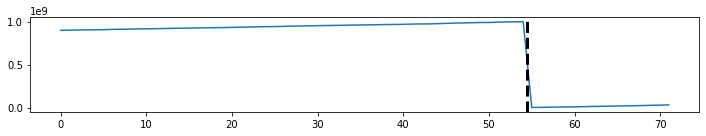

Normalized (smart_9_normalized)


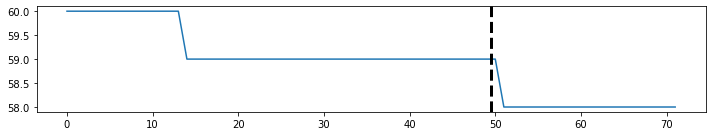

Power-On Hours Count (smart_9_raw)


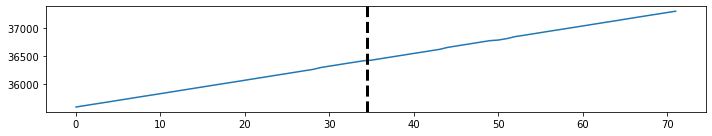

Normalized (smart_10_normalized)


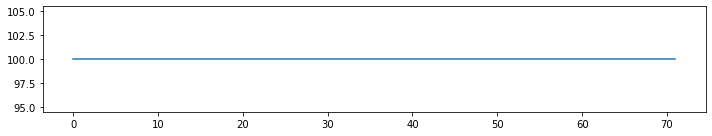

Spin-up Retries (smart_10_raw)


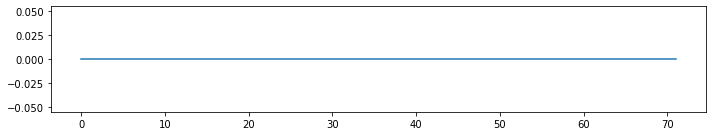

Normalized (smart_12_normalized)


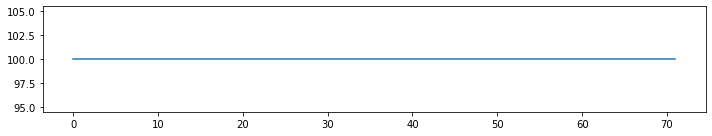

Power Cycle Count (smart_12_raw)


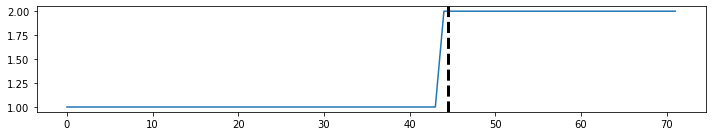

Normalized (smart_183_normalized)


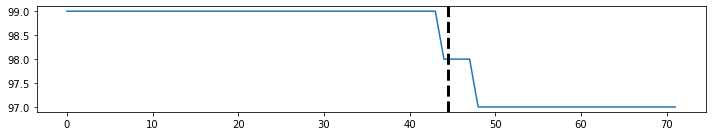

SATA Downshifts (smart_183_raw)


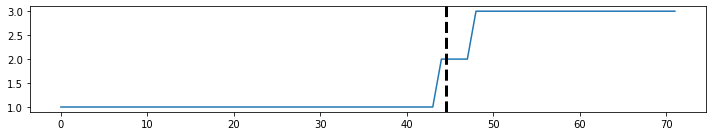

Normalized (smart_184_normalized)


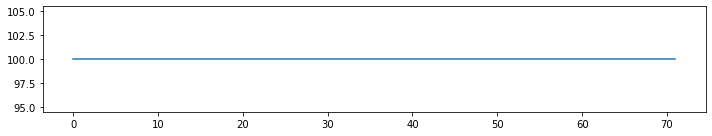

End-to-End error (smart_184_raw)


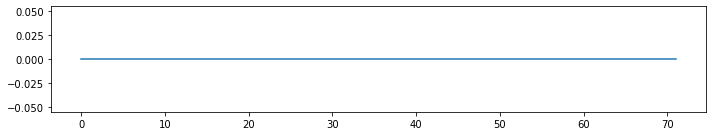

Normalized (smart_187_normalized)


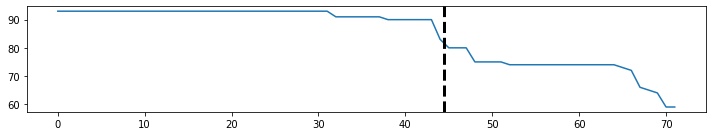

Reported Uncorrectable Errors (smart_187_raw)


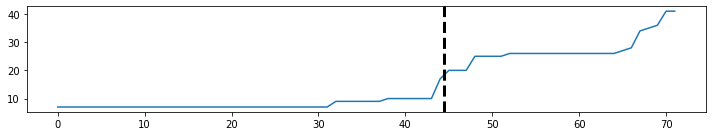

Normalized (smart_188_normalized)


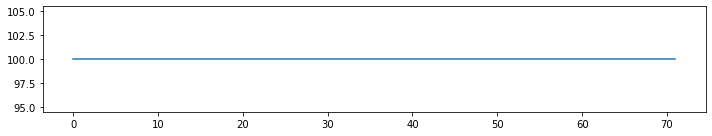

Command Timeout (smart_188_raw)


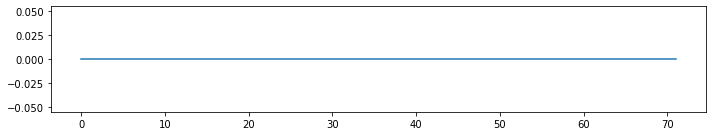

Normalized (smart_189_normalized)


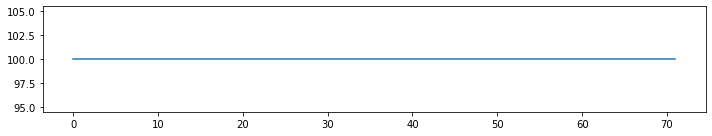

High Fly Writes (smart_189_raw)


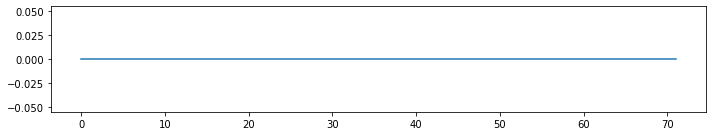

Normalized (smart_190_normalized)


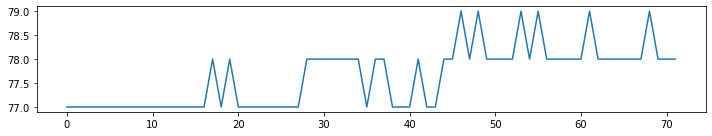

Temperature (smart_190_raw)


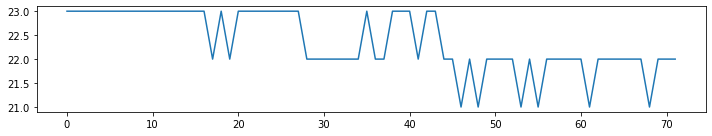

Normalized (smart_191_normalized)


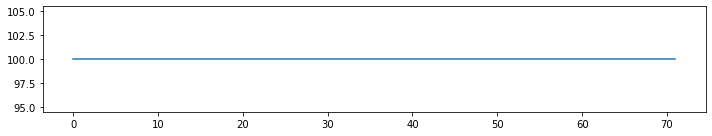

G-Sense Errors (smart_191_raw)


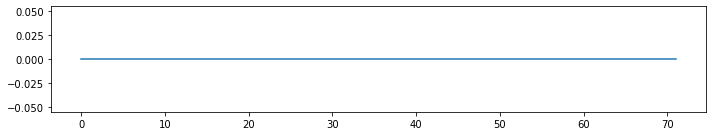

Normalized (smart_192_normalized)


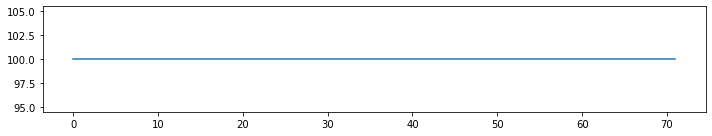

Power-Off Retract Cycles (smart_192_raw)


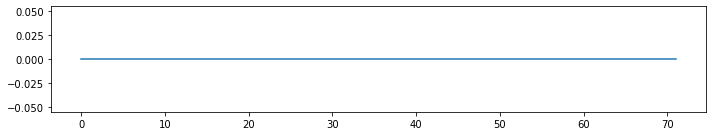

Normalized (smart_193_normalized)


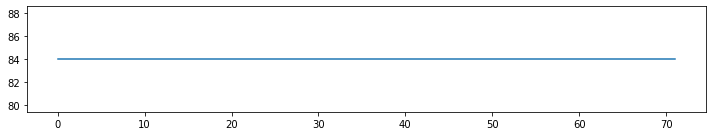

Load/Unload Cycles (smart_193_raw)


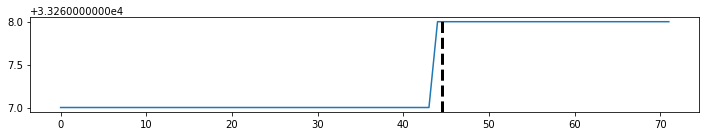

Normalized (smart_194_normalized)


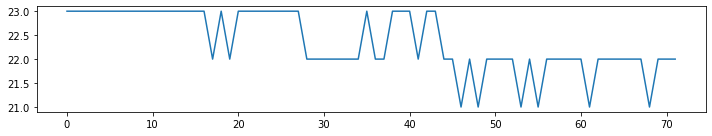

Temperature (smart_194_raw)


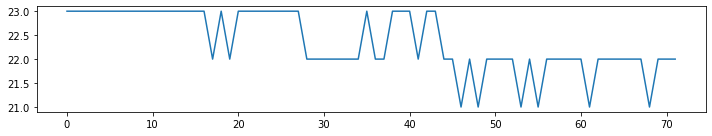

Normalized (smart_197_normalized)


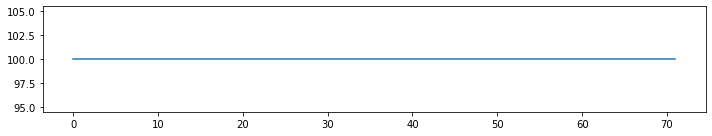

Current Pending Sectors (smart_197_raw)


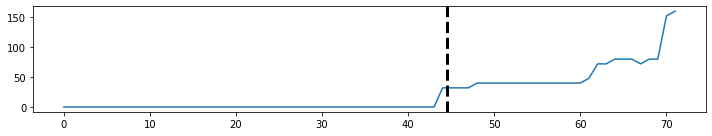

Normalized (smart_198_normalized)


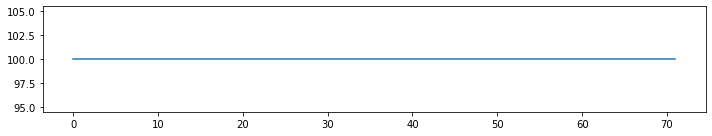

Off-line Uncorrectable (smart_198_raw)


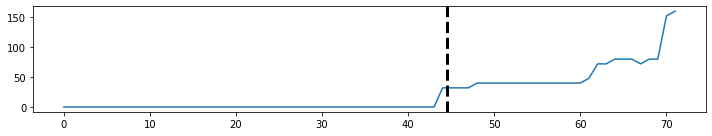

Normalized (smart_199_normalized)


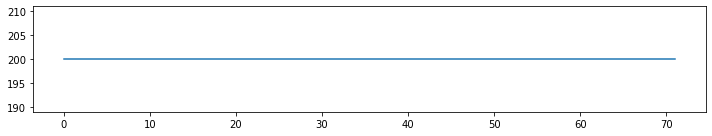

UDMA CRC Error Rate (smart_199_raw)


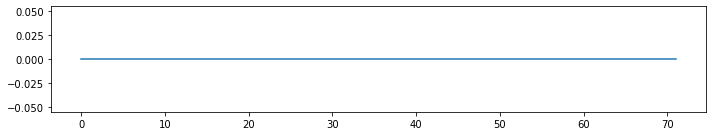

Normalized (smart_240_normalized)


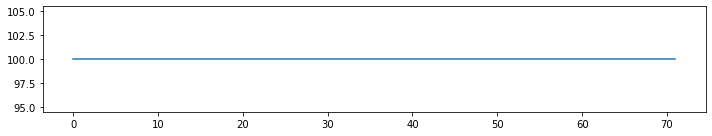

Head Flying Hours (smart_240_raw)


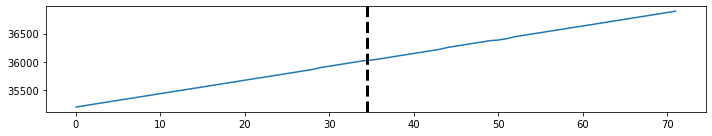

Normalized (smart_241_normalized)


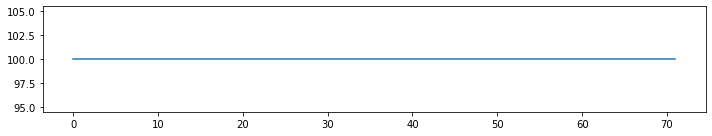

Total LBAs Written (smart_241_raw)


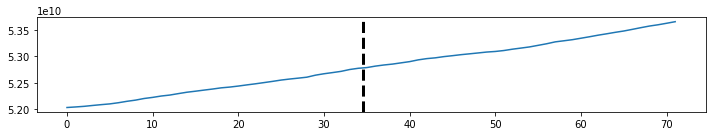

Normalized (smart_242_normalized)


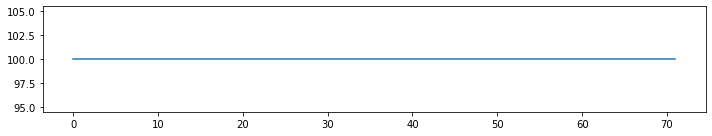

Total LBAs Read (smart_242_raw)


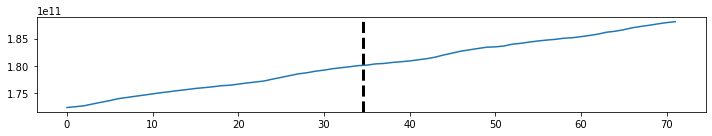

Counter({'smart_3_normalized': 1, 'smart_4_raw': 1, 'smart_7_raw': 1, 'smart_9_normalized': 1, 'smart_9_raw': 1, 'smart_12_raw': 1, 'smart_183_normalized': 1, 'smart_183_raw': 1, 'smart_187_normalized': 1, 'smart_187_raw': 1, 'smart_193_raw': 1, 'smart_197_raw': 1, 'smart_198_raw': 1, 'smart_240_raw': 1, 'smart_241_raw': 1, 'smart_242_raw': 1, 'smart_1_normalized': 0, 'smart_1_raw': 0, 'smart_3_raw': 0, 'smart_4_normalized': 0, 'smart_5_normalized': 0, 'smart_5_raw': 0, 'smart_7_normalized': 0, 'smart_10_normalized': 0, 'smart_10_raw': 0, 'smart_12_normalized': 0, 'smart_184_normalized': 0, 'smart_184_raw': 0, 'smart_188_normalized': 0, 'smart_188_raw': 0, 'smart_189_normalized': 0, 'smart_189_raw': 0, 'smart_190_normalized': 0, 'smart_190_raw': 0, 'smart_191_normalized': 0, 'smart_191_raw': 0, 'smart_192_normalized': 0, 'smart_192_raw': 0, 'smart_193_normalized': 0, 'smart_194_normalized': 0, 'smart_194_raw': 0, 'smart_197_normalized': 0, 'smart_198_normalized': 0, 'smart_199_normaliz

In [109]:
case_df2 = drive_df_preprocess(case_df, date_as_index=True)
print(smart_changepoints(case_df2, display=True))


For this particular drive, these parameters changed:
- Start/Stop Count, Power Cycle Count: the drive was restarted around 30 days before its failure
- Seek Error Rate
- SATA Downshifts
- Reported Uncorrectable Errors
- Load/Unload Cycles
- Current Pending Sectors
- Off-line Uncorrectable

In [19]:
evaluation_drive_set = failed_st4000dm000_drives.loc['2019-02-15':]
evaluation_drive_set

,serial_number
date,
2019-02-15,Z304HV83
2019-02-16,Z304HTKM
2019-02-18,S300XCAB
2019-02-18,Z30251BE
2019-02-21,Z302T6J5
...,...
2020-12-24,Z304HV25
2020-12-25,S301GQPM
2020-12-25,Z305D5CQ


In [132]:
evaluation_drive_set2 = failed_st12000nm0007_drives['2019-03-01':]
evaluation_drive_set2

,serial_number
date,
2019-03-01,ZCH0547F
2019-03-01,ZJV1L5N1
2019-03-02,ZCH07NZM
2019-03-03,ZCH0BNS3
2019-03-03,ZCH0BWVW
...,...
2020-12-21,ZCH06GVN
2020-12-23,ZJV5GMMD
2020-12-26,ZJV5ND3B


In [131]:
def generate_evaluation_df(model: str, evaluation_set: pd.DataFrame, test=False):
    column_names = "date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_16_normalized,smart_16_raw,smart_17_normalized,smart_17_raw,smart_18_normalized,smart_18_raw,smart_22_normalized,smart_22_raw,smart_23_normalized,smart_23_raw,smart_24_normalized,smart_24_raw,smart_168_normalized,smart_168_raw,smart_170_normalized,smart_170_raw,smart_173_normalized,smart_173_raw,smart_174_normalized,smart_174_raw,smart_177_normalized,smart_177_raw,smart_179_normalized,smart_179_raw,smart_181_normalized,smart_181_raw,smart_182_normalized,smart_182_raw,smart_183_normalized,smart_183_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_189_normalized,smart_189_raw,smart_190_normalized,smart_190_raw,smart_191_normalized,smart_191_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_195_normalized,smart_195_raw,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_200_normalized,smart_200_raw,smart_201_normalized,smart_201_raw,smart_218_normalized,smart_218_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_231_normalized,smart_231_raw,smart_232_normalized,smart_232_raw,smart_233_normalized,smart_233_raw,smart_235_normalized,smart_235_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw"
    column_names = column_names.split(",")

    evaluation_drives = list(evaluation_set.serial_number.values)

    evaluation_df = pd.DataFrame(columns=column_names)

    files = [
        "data/Q1_2019.csv",
    ]

    if not test:
        files.extend(
            [
                "data/Q2_2019.csv",
                "data/Q3_2019.csv",
                "data/Q4_2019.csv",
                "data/Q1_2020.csv",
                "data/Q2_2020.csv",
                "data/Q3_2020.csv",
                "data/Q4_2020.csv",
            ]
        )

    for filename in files:
        print(f"Processing {filename}")
        with pd.read_csv(filename, chunksize=100000) as current_df:
            for chunk in current_df:
                chunk = chunk[(chunk.model == model) & (chunk.serial_number.isin(evaluation_drives))]
                common_columns = [
                    col for col in chunk.columns if col in evaluation_df.columns
                ]
                evaluation_df = evaluation_df.append(chunk[common_columns])
        print(f"{filename} done")

    return evaluation_df


In [21]:
# Very time consuming
# evaluation_df = generate_evaluation_df("ST4000DM000", evaluation_drive_set)
# evaluation_df

evaluation_df = pd.read_pickle("data/evaluation_df")

In [151]:
# evaluation_df2 = generate_evaluation_df("ST12000NM0007", evaluation_drive_set2)
# evaluation_df2

evaluation_df2 = pd.read_pickle("data/evaluation_df2")

In [139]:
list(evaluation_drive_set2.values)

[array(['ZCH0547F'], dtype=object),
 array(['ZJV1L5N1'], dtype=object),
 array(['ZCH07NZM'], dtype=object),
 array(['ZCH0BNS3'], dtype=object),
 array(['ZCH0BWVW'], dtype=object),
 array(['ZCH06WEZ'], dtype=object),
 array(['ZCH0CN2T'], dtype=object),
 array(['ZCH0783C'], dtype=object),
 array(['ZCH0817E'], dtype=object),
 array(['ZJV02GJM'], dtype=object),
 array(['ZJV03Y00'], dtype=object),
 array(['ZCH0DY2X'], dtype=object),
 array(['ZJV058H7'], dtype=object),
 array(['ZCH09MGG'], dtype=object),
 array(['ZJV2QMLV'], dtype=object),
 array(['ZJV03VVA'], dtype=object),
 array(['ZCH06WPN'], dtype=object),
 array(['ZCH0681Z'], dtype=object),
 array(['ZCH06H3V'], dtype=object),
 array(['ZCH06J46'], dtype=object),
 array(['ZCH06EE3'], dtype=object),
 array(['ZCH0D1BJ'], dtype=object),
 array(['ZCH07C5S'], dtype=object),
 array(['ZCH0CE3Z'], dtype=object),
 array(['ZCH0BMQB'], dtype=object),
 array(['ZCH06FLV'], dtype=object),
 array(['ZJV2E903'], dtype=object),
 array(['ZCH0C00R'], dtype=o

In [111]:
clean_evaluation_df = drive_df_preprocess(evaluation_df, date_as_index=True)
clean_evaluation_df


,serial_number,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,Z302BV7C,0,119.0,231195280.0,93.0,0.0,100.0,7.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,30503.0,100.0,5.403677e+10,100.0,1.219510e+11
2019-01-01,Z302T6HP,0,119.0,213358112.0,92.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,28626.0,100.0,5.050805e+10,100.0,1.052247e+11
2019-01-01,Z304JKQW,0,117.0,147263032.0,91.0,0.0,100.0,14.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,28277.0,100.0,4.922136e+10,100.0,1.298128e+11
2019-01-01,Z305D2NT,0,119.0,233925808.0,91.0,0.0,100.0,10.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,25274.0,100.0,4.198461e+10,100.0,1.190565e+11
2019-01-01,Z304JDL3,0,117.0,162816872.0,94.0,0.0,100.0,6.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,28276.0,100.0,4.868509e+10,100.0,1.373655e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,S301GQPM,1,117.0,139328296.0,91.0,0.0,100.0,11.0,100.0,0.0,...,100.0,8.0,200.0,0.0,100.0,45063.0,100.0,5.913021e+10,100.0,9.212493e+11
2020-12-25,Z305D5CQ,1,117.0,143646232.0,92.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,42929.0,100.0,5.822963e+10,100.0,9.205509e+11
2020-12-25,Z305CVD1,1,117.0,137479016.0,93.0,0.0,100.0,7.0,99.0,1656.0,...,100.0,88.0,200.0,0.0,100.0,42663.0,100.0,5.422008e+10,100.0,2.641611e+11


In [141]:
# clean_evaluation_df2 = drive_df_preprocess(evaluation_df2, date_as_index=True)
# clean_evaluation_df2


,serial_number,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_199_normalized,smart_199_raw,smart_200_normalized,smart_200_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,ZCH080T0,0,84.0,235330528.0,94.0,0.0,100.0,5.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,10021.0,100.0,5.349964e+10,100.0,8.614009e+10
2019-01-01,ZCH080T7,0,82.0,169680112.0,97.0,0.0,100.0,3.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,10019.0,100.0,5.358288e+10,100.0,9.331545e+10
2019-01-01,ZJV0WGMA,0,83.0,199595048.0,96.0,0.0,100.0,3.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,3018.0,100.0,2.850615e+10,100.0,2.100994e+10
2019-01-01,ZJV0WG22,0,83.0,217093720.0,99.0,0.0,100.0,1.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,4164.0,100.0,3.244927e+10,100.0,5.809995e+10
2019-01-01,ZCH0BW17,0,82.0,169816656.0,97.0,0.0,100.0,3.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,8467.0,100.0,4.922419e+10,100.0,7.911955e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,ZCH0810C,0,83.0,180938672.0,90.0,0.0,100.0,8.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,11183.0,100.0,5.428453e+10,100.0,1.469003e+11
2020-12-31,ZJV05ERJ,0,83.0,187525128.0,89.0,0.0,100.0,17.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,10899.0,100.0,8.643513e+10,100.0,1.152244e+11
2020-12-31,ZCH0CAKT,0,73.0,18643464.0,98.0,0.0,100.0,2.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,5321.0,100.0,3.581589e+10,100.0,8.383230e+10


In [112]:
filtered_evaluation_df = clean_evaluation_df.sort_index().groupby("serial_number").tail(60)
filtered_evaluation_df


,serial_number,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,S301GM66,0,106.0,11613224.0,91.0,0.0,100.0,23.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,28693.0,100.0,2.610593e+10,100.0,3.323606e+11
2019-01-01,S301NH5Z,0,118.0,188314152.0,92.0,0.0,100.0,8.0,98.0,1944.0,...,100.0,0.0,200.0,0.0,100.0,26219.0,100.0,2.838266e+10,100.0,1.280224e+11
2019-01-01,S3010LCN,0,112.0,48458832.0,96.0,0.0,100.0,4.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,31646.0,100.0,5.383677e+10,100.0,1.151631e+11
2019-01-01,Z304HV83,0,110.0,26594360.0,93.0,0.0,100.0,7.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,27310.0,100.0,4.460782e+10,100.0,1.294132e+11
2019-01-01,S300ZQVL,0,116.0,105725632.0,92.0,0.0,100.0,9.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,30383.0,100.0,5.476484e+10,100.0,1.168070e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,S301GQPM,1,117.0,139328296.0,91.0,0.0,100.0,11.0,100.0,0.0,...,100.0,8.0,200.0,0.0,100.0,45063.0,100.0,5.913021e+10,100.0,9.212493e+11
2020-12-25,Z305D5CQ,1,117.0,143646232.0,92.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,42929.0,100.0,5.822963e+10,100.0,9.205509e+11
2020-12-25,Z305CVD1,1,117.0,137479016.0,93.0,0.0,100.0,7.0,99.0,1656.0,...,100.0,88.0,200.0,0.0,100.0,42663.0,100.0,5.422008e+10,100.0,2.641611e+11


In [142]:
# filtered_evaluation_df2 = clean_evaluation_df2.sort_index().groupby("serial_number").tail(60)
# filtered_evaluation_df2

,serial_number,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_199_normalized,smart_199_raw,smart_200_normalized,smart_200_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,ZCH092S4,0,82.0,153671371.0,96.0,0.0,100.0,3.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,2832.0,100.0,1.708544e+10,100.0,5.783045e+10
2019-01-01,ZCH0547F,0,78.0,60992272.0,94.0,0.0,100.0,5.0,100.0,8.0,...,200.0,0.0,100.0,0.0,100.0,10017.0,100.0,5.118835e+10,100.0,8.681222e+10
2019-01-01,ZJV1L5N1,0,82.0,148150248.0,96.0,0.0,100.0,3.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,1546.0,100.0,1.537073e+10,100.0,1.724821e+10
2019-01-02,ZCH092S4,0,82.0,171787976.0,96.0,0.0,100.0,3.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,2856.0,100.0,1.728283e+10,100.0,5.789531e+10
2019-01-02,ZCH07NZM,0,73.0,20037464.0,96.0,0.0,100.0,4.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,10280.0,100.0,5.528704e+10,100.0,9.146163e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,ZCH0810C,0,83.0,180938672.0,90.0,0.0,100.0,8.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,11183.0,100.0,5.428453e+10,100.0,1.469003e+11
2020-12-31,ZJV05ERJ,0,83.0,187525128.0,89.0,0.0,100.0,17.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,10899.0,100.0,8.643513e+10,100.0,1.152244e+11
2020-12-31,ZCH0CAKT,0,73.0,18643464.0,98.0,0.0,100.0,2.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,5321.0,100.0,3.581589e+10,100.0,8.383230e+10


In [150]:
# clean_evaluation_df2[clean_evaluation_df2["serial_number"] == "ZCH06VE2"]

,serial_number,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_199_normalized,smart_199_raw,smart_200_normalized,smart_200_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,ZCH06VE2,0,84.0,238623624.0,94.0,0.0,100.0,5.0,98.0,8320.0,...,200.0,0.0,100.0,0.0,100.0,9034.0,100.0,4.960361e+10,100.0,5.390665e+10
2019-01-02,ZCH06VE2,0,83.0,200987336.0,94.0,0.0,100.0,5.0,98.0,8320.0,...,200.0,0.0,100.0,0.0,100.0,9052.0,100.0,4.966390e+10,100.0,5.405286e+10
2019-01-03,ZCH06VE2,0,83.0,219795552.0,94.0,0.0,100.0,5.0,98.0,8320.0,...,200.0,0.0,100.0,0.0,100.0,9074.0,100.0,4.974209e+10,100.0,5.423762e+10
2019-01-04,ZCH06VE2,0,74.0,24115488.0,94.0,0.0,100.0,5.0,98.0,8320.0,...,200.0,0.0,100.0,0.0,100.0,9099.0,100.0,4.980984e+10,100.0,5.446248e+10
2019-01-05,ZCH06VE2,0,82.0,153845992.0,94.0,0.0,100.0,5.0,98.0,8320.0,...,200.0,0.0,100.0,0.0,100.0,9123.0,100.0,4.992793e+10,100.0,5.471826e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,ZCH06VE2,0,79.0,80322704.0,96.0,0.0,100.0,3.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,7526.0,100.0,4.656129e+10,100.0,1.036659e+11
2020-12-28,ZCH06VE2,0,83.0,215394920.0,96.0,0.0,100.0,3.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,7542.0,100.0,4.657166e+10,100.0,1.037906e+11
2020-12-29,ZCH06VE2,0,78.0,69199008.0,96.0,0.0,100.0,3.0,100.0,0.0,...,200.0,0.0,100.0,0.0,100.0,7574.0,100.0,4.659540e+10,100.0,1.041089e+11


In [113]:
filtered_evaluation_df[filtered_evaluation_df.serial_number == "S301GQPM"]

,serial_number,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
date,,,,,,,,,,,,,,,,,,,,,
2020-10-27,S301GQPM,0,111.0,36453760.0,91.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,43652.0,100.0,5.848886e+10,100.0,9.094031e+11
2020-10-28,S301GQPM,0,119.0,1152096.0,91.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,43675.0,100.0,5.850267e+10,100.0,9.096814e+11
2020-10-29,S301GQPM,0,117.0,166104880.0,91.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,43687.0,100.0,5.850768e+10,100.0,9.098349e+11
2020-10-30,S301GQPM,0,117.0,128850856.0,91.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,43711.0,100.0,5.852116e+10,100.0,9.100159e+11
2020-10-31,S301GQPM,0,118.0,168124264.0,91.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,43746.0,100.0,5.853362e+10,100.0,9.101715e+11
2020-11-01,S301GQPM,0,115.0,99684864.0,91.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,43770.0,100.0,5.854876e+10,100.0,9.103872e+11
2020-11-02,S301GQPM,0,111.0,40144496.0,91.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,43793.0,100.0,5.857068e+10,100.0,9.105801e+11
2020-11-03,S301GQPM,0,115.0,98979080.0,91.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,43817.0,100.0,5.858596e+10,100.0,9.106948e+11
2020-11-04,S301GQPM,0,113.0,57937352.0,91.0,0.0,100.0,11.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,43841.0,100.0,5.859581e+10,100.0,9.109460e+11


Normalized (smart_1_normalized)


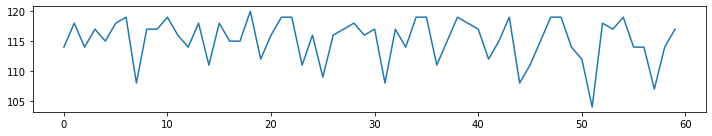

Read Error Rate (smart_1_raw)


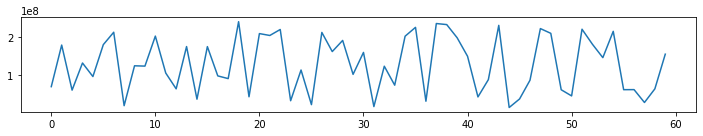

Normalized (smart_3_normalized)


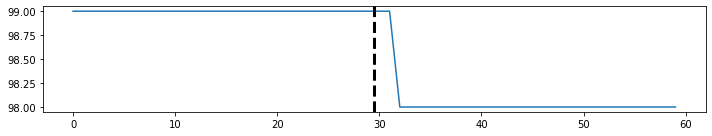

Spin-Up Time (smart_3_raw)


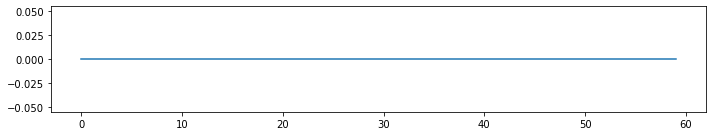

Normalized (smart_4_normalized)


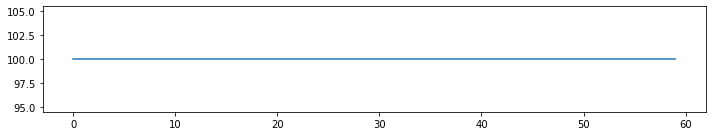

Start/Stop Count (smart_4_raw)


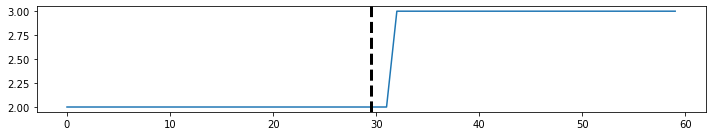

Normalized (smart_5_normalized)


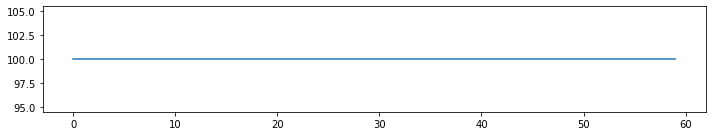

Reallocated Sectors Count (smart_5_raw)


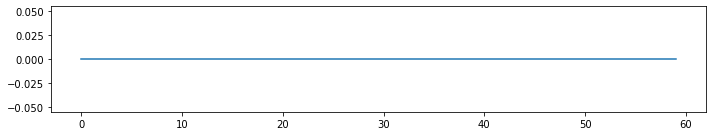

Normalized (smart_7_normalized)


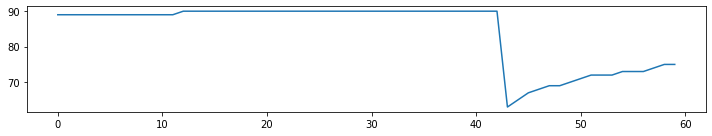

Seek Error Rate (smart_7_raw)


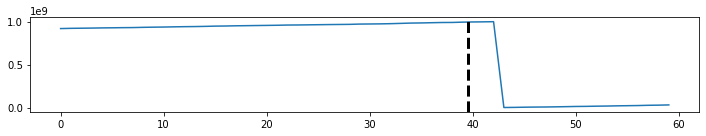

Normalized (smart_9_normalized)


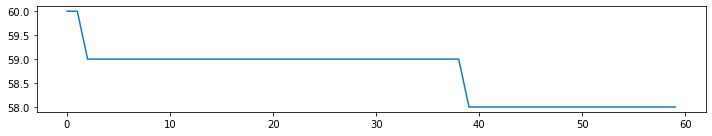

Power-On Hours Count (smart_9_raw)


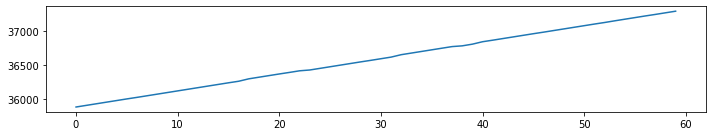

Normalized (smart_10_normalized)


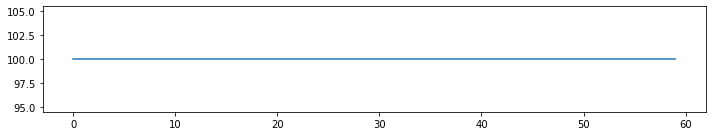

Spin-up Retries (smart_10_raw)


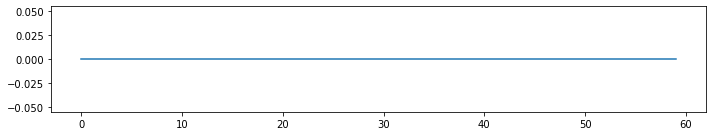

Normalized (smart_12_normalized)


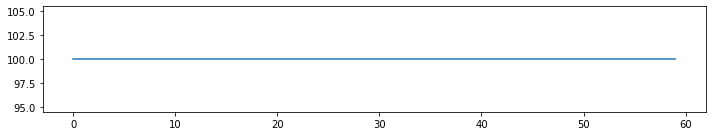

Power Cycle Count (smart_12_raw)


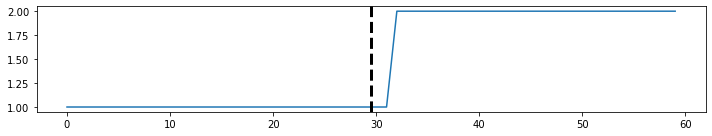

Normalized (smart_183_normalized)


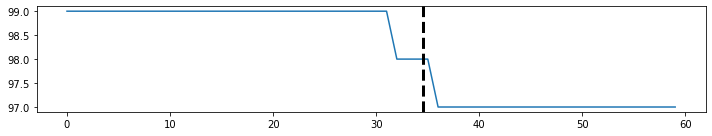

SATA Downshifts (smart_183_raw)


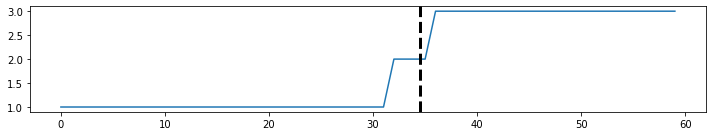

Normalized (smart_184_normalized)


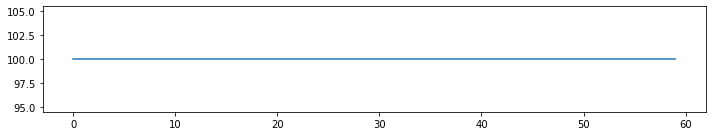

End-to-End error (smart_184_raw)


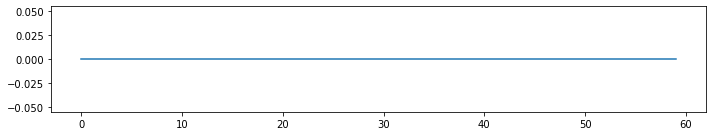

Normalized (smart_187_normalized)


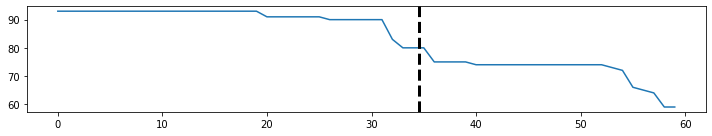

Reported Uncorrectable Errors (smart_187_raw)


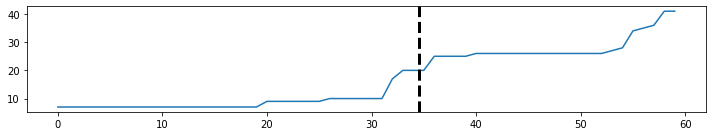

Normalized (smart_188_normalized)


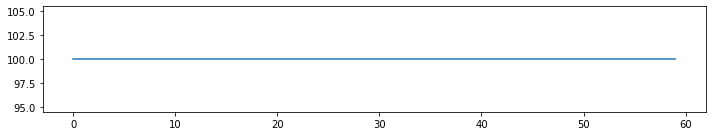

Command Timeout (smart_188_raw)


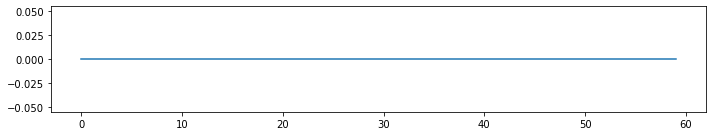

Normalized (smart_189_normalized)


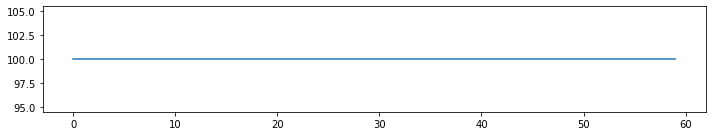

High Fly Writes (smart_189_raw)


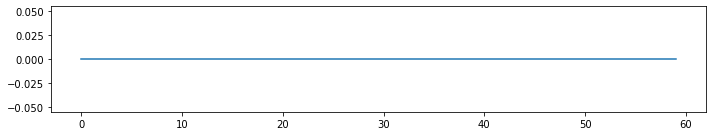

Normalized (smart_190_normalized)


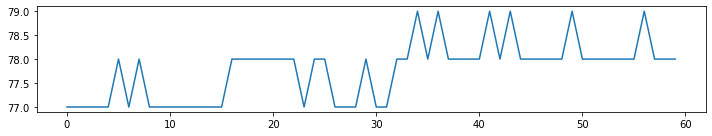

Temperature (smart_190_raw)


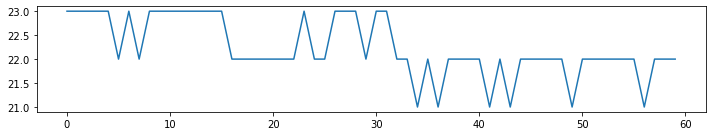

Normalized (smart_191_normalized)


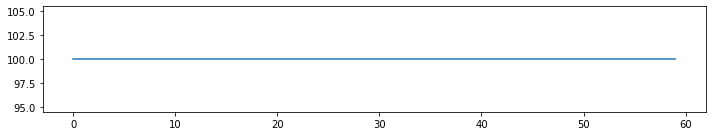

G-Sense Errors (smart_191_raw)


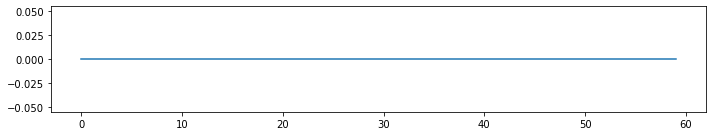

Normalized (smart_192_normalized)


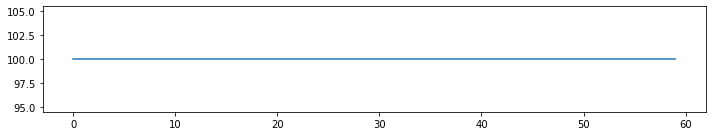

Power-Off Retract Cycles (smart_192_raw)


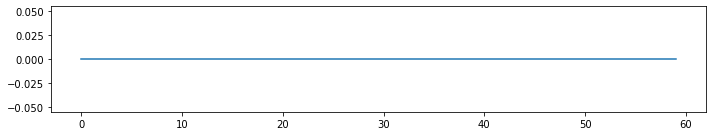

Normalized (smart_193_normalized)


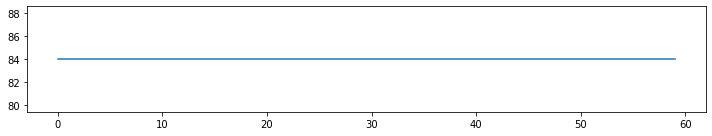

Load/Unload Cycles (smart_193_raw)


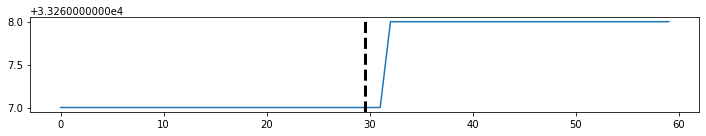

Normalized (smart_194_normalized)


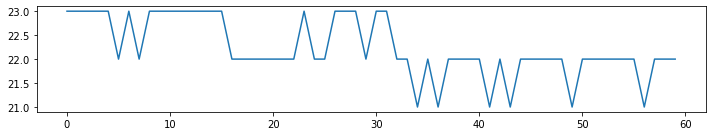

Temperature (smart_194_raw)


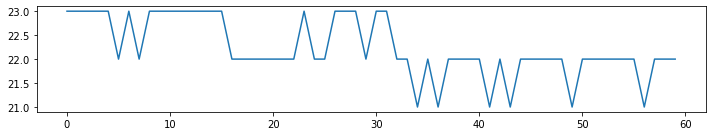

Normalized (smart_197_normalized)


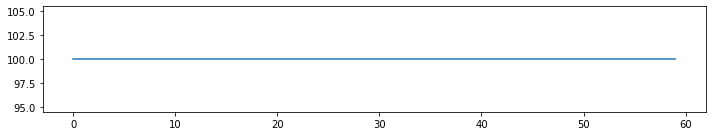

Current Pending Sectors (smart_197_raw)


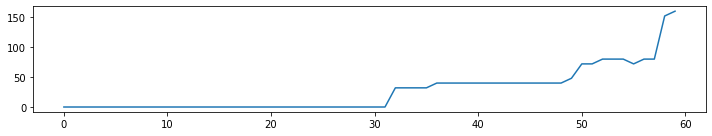

Normalized (smart_198_normalized)


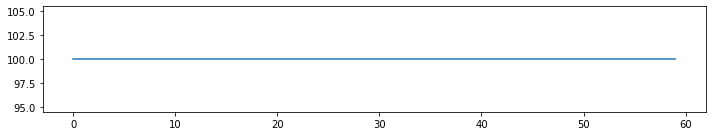

Off-line Uncorrectable (smart_198_raw)


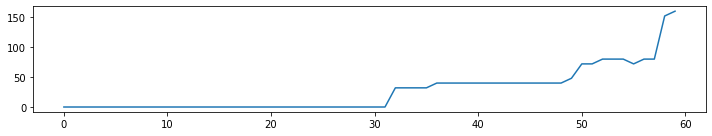

Normalized (smart_199_normalized)


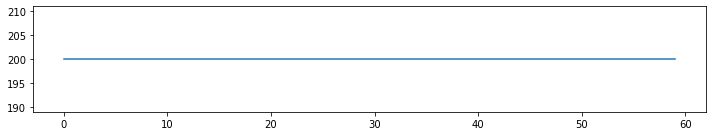

UDMA CRC Error Rate (smart_199_raw)


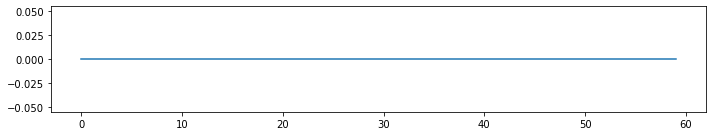

Normalized (smart_240_normalized)


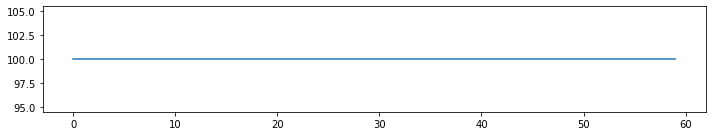

Head Flying Hours (smart_240_raw)


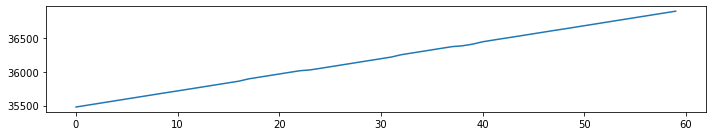

Normalized (smart_241_normalized)


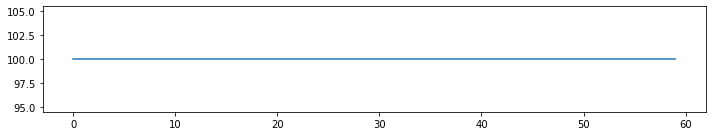

Total LBAs Written (smart_241_raw)


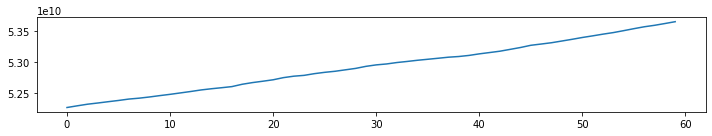

Normalized (smart_242_normalized)


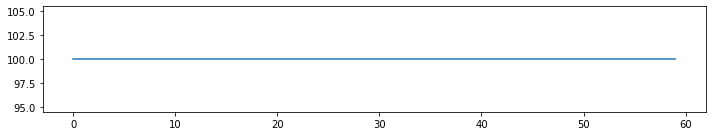

Total LBAs Read (smart_242_raw)


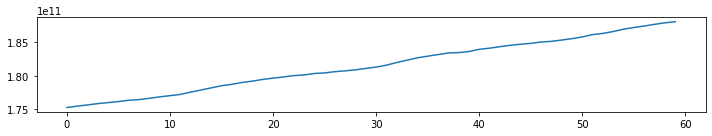

Counter({'smart_1_normalized': 0,
         'smart_1_raw': 0,
         'smart_3_normalized': 1,
         'smart_3_raw': 0,
         'smart_4_normalized': 0,
         'smart_4_raw': 1,
         'smart_5_normalized': 0,
         'smart_5_raw': 0,
         'smart_7_normalized': 0,
         'smart_7_raw': 1,
         'smart_9_normalized': 0,
         'smart_9_raw': 0,
         'smart_10_normalized': 0,
         'smart_10_raw': 0,
         'smart_12_normalized': 0,
         'smart_12_raw': 1,
         'smart_183_normalized': 1,
         'smart_183_raw': 1,
         'smart_184_normalized': 0,
         'smart_184_raw': 0,
         'smart_187_normalized': 1,
         'smart_187_raw': 1,
         'smart_188_normalized': 0,
         'smart_188_raw': 0,
         'smart_189_normalized': 0,
         'smart_189_raw': 0,
         'smart_190_normalized': 0,
         'smart_190_raw': 0,
         'smart_191_normalized': 0,
         'smart_191_raw': 0,
         'smart_192_normalized': 0,
         'smart_1

In [114]:
smart_changepoints(filtered_evaluation_df[filtered_evaluation_df.serial_number == "Z305AQY2"], display=True)

In [26]:
def total_changepoints(df: pd.DataFrame, drive_set: pd.DataFrame):
    evaluation_drives = list(drive_set.serial_number.values)
    total_counter = Counter()
    for drive in evaluation_drives:
        total_counter += smart_changepoints(df[df.serial_number == drive])
    
    return total_counter

In [115]:
most_frequent_changepoints = total_changepoints(filtered_evaluation_df, evaluation_drive_set).most_common()
cp_df = pd.DataFrame(most_frequent_changepoints, columns=["name", "count"])
cp_df["frequency"] = cp_df["count"] / len(evaluation_drive_set)

In [119]:
cp_df2 = cp_df.copy()
cp_df2["title"] = cp_df2["name"].map(lambda x: smart_dict.get(x, "Normalized"))
cp_df2 = cp_df2.set_index("name")
cp_df2.style.format({"frequency": "{:.2%}"})

,count,frequency,title
name,,,
smart_242_raw,269,43.74%,Total LBAs Read
smart_9_normalized,261,42.44%,Normalized
smart_241_raw,260,42.28%,Total LBAs Written
smart_7_raw,207,33.66%,Seek Error Rate
smart_7_normalized,158,25.69%,Normalized
smart_193_raw,132,21.46%,Load/Unload Cycles
smart_187_normalized,109,17.72%,Normalized
smart_187_raw,109,17.72%,Reported Uncorrectable Errors
smart_197_raw,93,15.12%,Current Pending Sectors


In [127]:
cp_df2[cp_df2.frequency > 0.01].style.format({"frequency": "{:.2%}"})

,count,frequency,title
name,,,
smart_242_raw,269,43.74%,Total LBAs Read
smart_9_normalized,261,42.44%,Normalized
smart_241_raw,260,42.28%,Total LBAs Written
smart_7_raw,207,33.66%,Seek Error Rate
smart_7_normalized,158,25.69%,Normalized
smart_193_raw,132,21.46%,Load/Unload Cycles
smart_187_normalized,109,17.72%,Normalized
smart_187_raw,109,17.72%,Reported Uncorrectable Errors
smart_197_raw,93,15.12%,Current Pending Sectors
